<a href="https://colab.research.google.com/github/ashfarhangi/Real-Time-Systems/blob/master/mem_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import time
sns.set()
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:

def get_memory(file):
#   open for reading
    with open(file, 'r') as fileopen:
        data = fileopen.read()
#       for spliting the numbers
    data = data.split()
    print('leng',len(data))
#     print(data)
# this is for finding duplicates and where the memeroy has duplicates occuring
    vocab = list(set(data))
    return data, vocab
# Easy way to use the recurring memories in this case:
#   We can one hot encode the words such as a word "the" would be onehot[1,the]=1
def embed_to_onehot(data, vocab):
    onehot = np.zeros((len(data), len(vocab)), dtype = np.float32)
    for i in range(len(data)):
        onehot[i, vocab.index(data[i])] = 1.0
    return onehot

In [0]:
text, text_vocab = get_memory('/content/gdrive/My Drive/Colab Notebooks/data/mem_2k.txt')
dup= len(text)-len(text_vocab)
print("Duplicates: ",dup)
print("Duplication stats %", dup / len(text) *100)

leng 2000
Duplicates:  483
Duplication stats % 24.15


In [0]:
#Modeling:
learning_rate = 0.01
batch_size = 30
sequence_length = 60
epoch = 250
num_layers = 2
size_layer = 256
possible_batch_id = range(len(text) - sequence_length - 1)
print('possible batch',possible_batch_id)
print(len(text))

possible batch range(0, 1939)
2000


In [0]:
class Model:
#    LSTM CELL
# Dimention = (2000) Lengh of text can build multi diementional text as well
    def __init__(self, num_layers, size_layer, dimension, sequence_length, learning_rate):
        def lstm_cell():
#         LSTMCELL(256,60)
            return tf.nn.rnn_cell.LSTMCell(size_layer, sequence_length, state_is_tuple = False)
        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_layers)], 
                                                     state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, dimension))
        self.Y = tf.placeholder(tf.float32, (None, None, dimension))
        self.hidden_layer = tf.placeholder(tf.float32, (None, num_layers * 2 * size_layer))
        self.outputs, self.last_state = tf.nn.dynamic_rnn(self.rnn_cells, self.X, 
                                                          initial_state = self.hidden_layer, 
                                                          dtype = tf.float32)
#         Weights = (256,2000)
        rnn_W = tf.Variable(tf.random_normal((size_layer, dimension)))
#         Bias = (2000)
        rnn_B = tf.Variable(tf.random_normal([dimension]))
#   z = Xw+b
        self.logits = tf.matmul(tf.reshape(self.outputs, [-1, size_layer]), rnn_W) + rnn_B
        y_batch_long = tf.reshape(self.Y, [-1, dimension])
#      the vector of raw (non-normalized) predictions that a classification model generates
# Means applying softmax to reduce the cost
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, 
                                                                           labels = y_batch_long))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(self.cost)
#     If the two numbers are exactly the same it is a correct predict
        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(y_batch_long, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        seq_shape = tf.shape(self.outputs)
        self.final_outputs = tf.reshape(tf.nn.softmax(self.logits), 
                                        (seq_shape[0], seq_shape[1], 
                                         dimension))

In [0]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(num_layers, size_layer, len(text_vocab), sequence_length, learning_rate)
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
W0630 14:43:31.307451 140431941347200 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7fb824f9be48>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0630 14:43:31.309001 140431941347200 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7fb8320d0ef0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


#Encoding:

In [0]:
def seq2seq():
    SoftMaxLoss, FinalAccuracy = [], []
    pbar = tqdm(range(epoch), desc = 'epoch')
    for i in pbar:
        last_time = time.time()
        init_value = np.zeros((batch_size, num_layers * 2 * size_layer))
        batch_x = np.zeros((batch_size, sequence_length, len(text_vocab)))
        batch_y = np.zeros((batch_size, sequence_length, len(text_vocab)))
        batch_id = random.sample(possible_batch_id, batch_size)
        for n in range(sequence_length):
            id1 = embed_to_onehot([text[k + n] for k in batch_id], text_vocab)
            id2 = embed_to_onehot([text[k + n + 1] for k in batch_id], text_vocab)
            batch_x[:,n,:] = id1
            batch_y[:,n,:] = id2
        last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.hidden_layer: init_value})
        accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, 
                                                         model.Y: batch_y, 
                                                         model.hidden_layer: init_value})
        FinalAccuracy.append(accuracy); SoftMaxLoss.append(loss)
        init_value = last_state
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    return SoftMaxLoss, FinalAccuracy

In [0]:
SoftMaxLoss, FinalAccuracy = seq2seq()

epoch: 100%|██████████| 250/250 [01:00<00:00,  4.15it/s, accuracy=0.997, cost=0.0857]


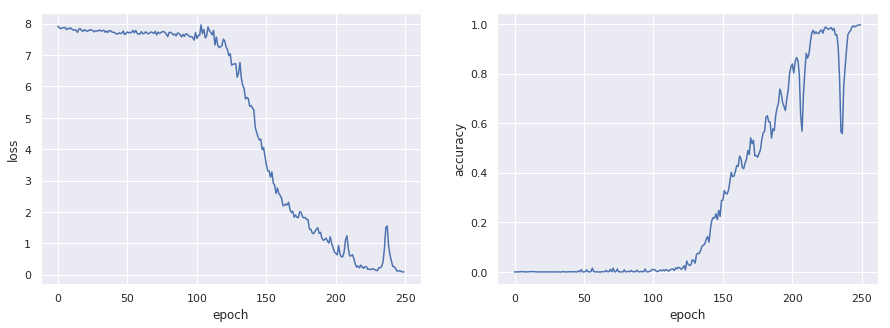

In [0]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(SoftMaxLoss))
plt.plot(EPOCH, SoftMaxLoss)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, FinalAccuracy)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()

In [0]:
split_text = text
print(len(text))
# selected_index = np.random.randint(0, len(split_text) - 5)
selected_index =1990
tag = split_text[selected_index:selected_index + 10]
print(tag)


2000
['881840', '882005', '223143', '1135943', '199128', '309093', '231203', '102033', '232463', '102034']


#Decoding:

In [0]:
def generate_based_sequence(length_sentence, argmax = False):
    sentence_generated = tag[:]
    onehot = embed_to_onehot(tag, text_vocab)
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for i in range(len(tag)):
        batch_x = np.zeros((1, 1, len(text_vocab)))
        batch_x[:, 0, :] = onehot[i, :]
#         IMPORTANT
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    for i in range(length_sentence):
        if argmax:
            index = np.argmax(prob[0][0])
        else:
            index = np.random.choice(range(len(text_vocab)), p = prob[0][0])
        element = [text_vocab[index]]
        sentence_generated += element
        onehot = embed_to_onehot(element, text_vocab)
        batch_x = np.zeros((1, 1, len(text_vocab)))
        batch_x[:, 0, :] = onehot[0, :]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    return ' '.join(sentence_generated)


In [0]:
ytest=[225497
,102033
,102034
,872806
,102651
,309125
,222507
,872807
,102078
,102729
]
print(ytest)
# print(generate_based_sequence(10,True))
# print(generate_based_sequence(10,False))

[225497, 102033, 102034, 872806, 102651, 309125, 222507, 872807, 102078, 102729]


In [0]:
seq_t = generate_based_sequence(10,True)
seq_r = generate_based_sequence(10,False)
print(len(seq_t))
print(len(seq_r))

140
140


In [0]:
arg4 = seq_t.split()
arg3 = seq_r.split()
#     print(data)
# this is for finding duplicates and where the memeroy has duplicates occuring
# print(len(arg3))
# arg3 = list(set(arg3))
# print(len(arg3))
for i in range(len(arg3)):
  arg3[i] = int(arg3[i])
  
# arg4 = list(set(arg4))
for i in range(len(arg4)):
  arg4[i] = int(arg4[i])

In [0]:
arg2 = text[1990:2000]
# arg2 =pd.DataFrame(arg2)
for i in range(len(arg2)):
  arg2[i] = int(arg2[i])

In [0]:
print(ytest, "Real Memory")
print(arg3[10:], "Predicted")
print(arg4[10:])

[225497, 102033, 102034, 872806, 102651, 309125, 222507, 872807, 102078, 102729] Real Memory
[221077, 617758, 102033, 467382, 215451, 467406, 689614, 219769, 467430, 102034] Predicted
[221077, 217943, 102033, 102034, 810847, 232651, 102651, 102648, 223647, 102642]


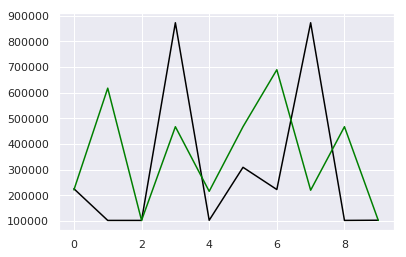

In [0]:
plt.plot(ytest[:],c='black')
plt.plot(arg3[10:],c='green')
# plt.plot(arg4[10:],c='yellow')
plt.show()

References:
https://towardsdatascience.com/aifortrading-2edd6fac689d